In [2]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

2025-09-12 14:56:15.988773: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-12 14:56:16.028553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-12 14:56:17.226500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# Define the paths for images and weights
image_dir = 'tf_ae/cartoon/images'
weights_dir = 'tf_ae/cartoon/training_weights'

# Create the directories
os.makedirs(image_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [4]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
img_height, img_width = 256, 256
batch_size = 128

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'cartoonset10k/',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 10000 files.


E0000 00:00:1757699778.504639   50208 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757699778.511646   50208 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2025-09-12 14:56:18.850482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


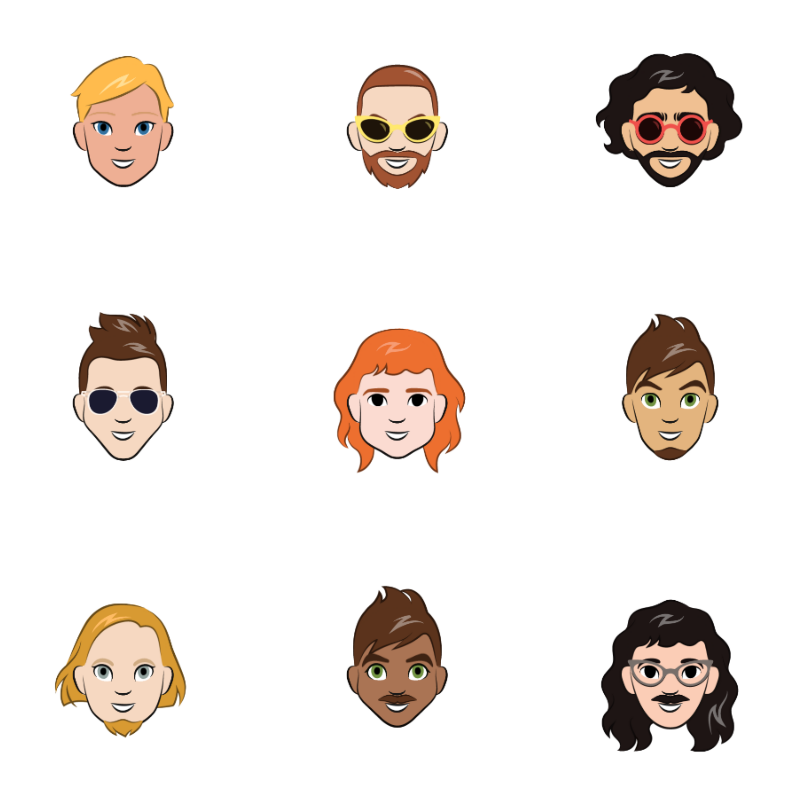

In [7]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
normalization_layer = layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [10]:
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [11]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [12]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
   
    
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(200, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [13]:
enc = encoder(input_encoder)

In [14]:
#enc.save('enc.h5')

In [15]:
enc.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_1 (LeakyReLU)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_2 (LeakyReLU)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_3 (LeakyReLU)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_4 (LeakyReLU)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 8, 8, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_5 (LeakyReLU)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       819,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 950,728 (3.63 MB)

 Trainable params: 950,152 (3.62 MB)

 Non-trainable params: 576 (2.25 KB)

In [16]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    #x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer')
    x = layers.Reshape((8,8,64), name='Reshape_Layer')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
  
    
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [17]:
dec = decoder(input_decoder)

In [18]:
dec.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Reshape_Layer (Reshape)         │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_1                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_1 (LeakyReLU)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_2                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_2 (LeakyReLU)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_3                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_3 (LeakyReLU)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_4                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lrelu_4 (LeakyReLU)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_5                │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,307 (3.64 MB)

 Trainable params: 953,859 (3.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
#dec.save('ae-cartoon-dec.h5')

In [20]:
#model.layers[1].get_weights()

In [21]:
#model.save('autoencoder.h5')

In [22]:
enc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
dec_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [23]:
def ae_loss(y_true, y_pred):
    #loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    #loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)))
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    
    enc_optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    dec_optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            #loss_.append(loss)

        #print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights(f'tf_ae/cartoon/training_weights/enc_{epoch}.weights.h5')
        dec.save_weights(f'tf_ae/cartoon/training_weights/dec_{epoch}.weights.h5')
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,dec],
                            epochs,
                            seed)

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    latent = enc(test_input, training=False)
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('tf_ae/cartoon/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()
    

    

(16, 256, 256, 3)


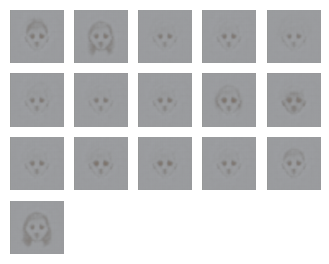

In [ ]:
train(normalized_ds, 30)

In [31]:
enc.load_weights('./tf_ae/cartoon/training_weights/enc_29.weights.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'tf_ae/cartoon/training_weights/enc_29.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
dec.load_weights('./tf_ae/cartoon/training_weights/dec_29.weights.h5')

In [30]:
embeddings = None
for i in normalized_ds:
    latent = enc.predict(i)
    if embeddings is None:
        embeddings = latent
    else:
        embeddings = np.concatenate((embeddings, latent))
    if embeddings.shape[0] > 5000:
        break

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━

In [ ]:
embeddings.shape

(5120, 200)

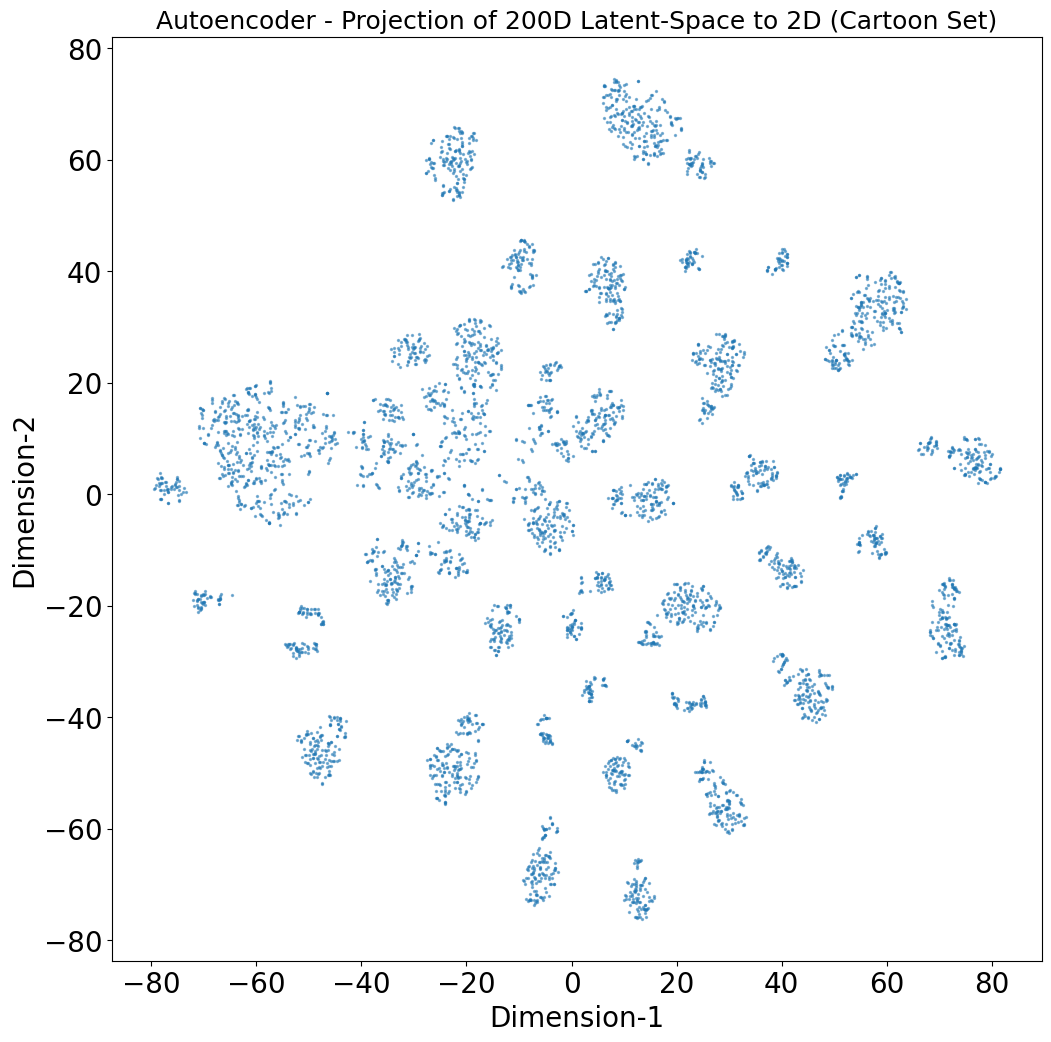

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Autoencoder - Projection of 200D Latent-Space to 2D (Cartoon Set)", size=18)
plt.show()

In [ ]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    latent= enc.predict(i)
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/ste

In [ ]:
reconstruction.shape

(5120, 256, 256, 3)

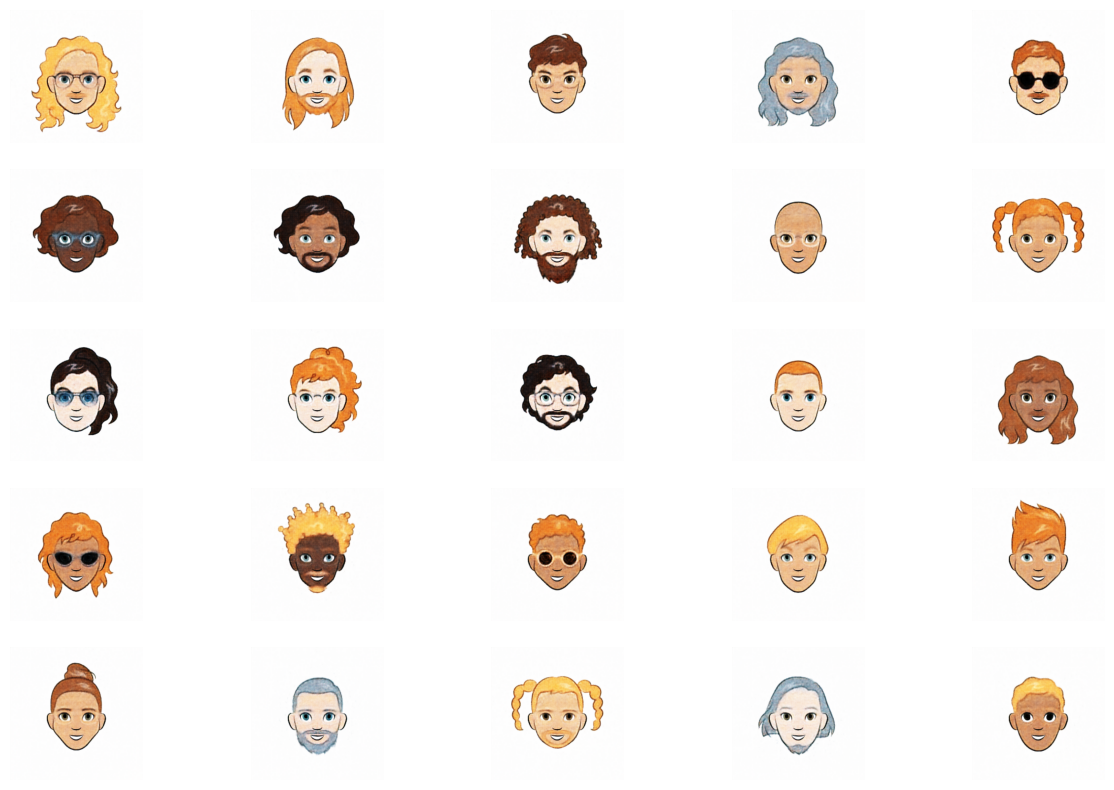

In [ ]:
figsize = 15

fig = plt.figure(figsize=(figsize, 10))
#fig.subplots_adjust(hspace=0.2, wspace=None)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

### Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

(10, 200)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


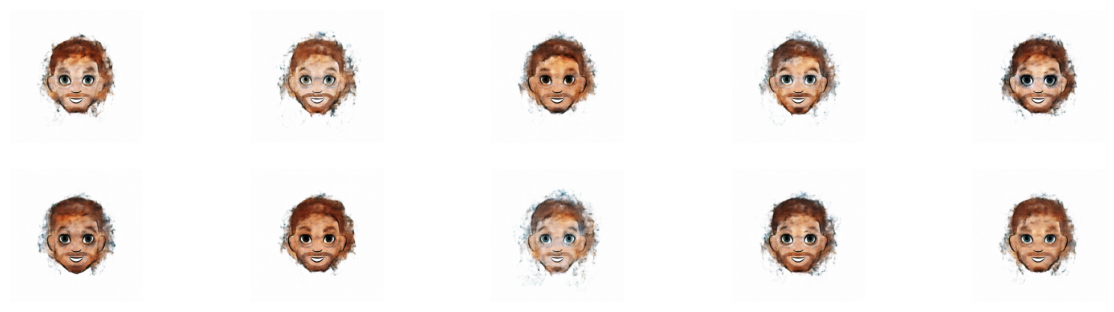

In [ ]:
figsize = 15

min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
# #print(max_x.shape, min_x.shape)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
#x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

## Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


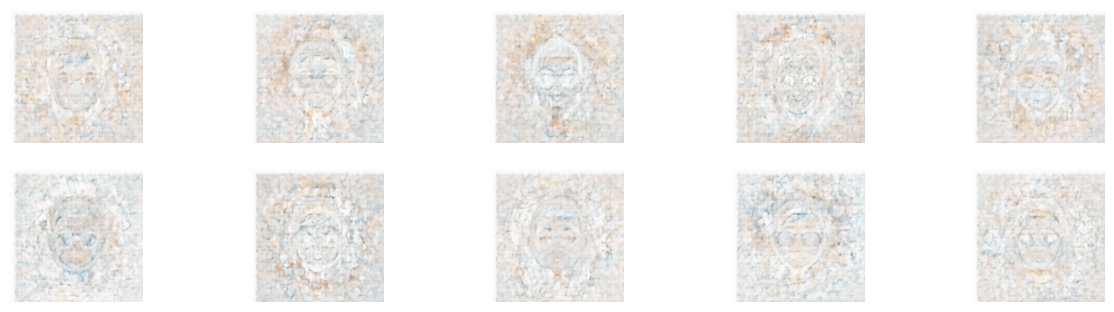

In [ ]:
x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)